In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from getdist import MCSamples, plots

import sys
sys.path.append("../")
from pldflow import plflow
from pldflow import sampler

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tutorial 2
In higher dimension, the integral is hard. 
In this notebook, I introduce the sampler, and explain how to use it to perform the integral by importance sampling.

Firstly, we prepare the PL model.

In [4]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    # Here the ndim is the dimension of x. 
    ndim = 2
    def action_s(self, z, y):
        zz = jnp.dot(z,z)
        # In this particular example, we use the additional `y`
        # in the same dimension as `z`, so we use `jnp.dot(z,y)`
        zy = jnp.dot(z,y) 
        return 1j * (zz + 2*zy)

In [5]:
# instantiate the model
fresnel = Fresnel()

## Conditional Sampler
The conditional probability distribution `sampler.ConditionallikelihoodSampler` samples
$$
P(x|p)
$$
where $x$ is the random variable(s) and $p$ is the conditioning parameter(s).

There is two way to get the samples of (x,y)
1. Sample `p` uniformly using e.g. Sobol sequence. For each sample of `p` as perform the sampling of `x`. This takes time
2. Assuming flat prior on `p`, we sample $P(x,p)$. In this way `y` can be randomize, but we cannot control the distribution of `y`.

For simplicity, we use the second approach.

## Our model
In our model 
$$
\begin{align}
Z 
&= \int {\rm d}x \det\left(\frac{\partial z}{\partial x}\right) e^{-S(z(x))}\\
&= \int {\rm d}x |J| e^{-\mathcal{Re}[S(z(x))]} e^{-\mathcal{Im}[S(z(x))]} \frac{J}{|J|}
\end{align}
$$
thus our probability distribution is
$$
P(x|y) = |J| e^{-\mathcal{Re}[S(z(x))]}
$$
As we discuss, we assume flat prior on $y$, and use `x`=$(x,y)$ and `p`=None.

In [6]:
# we define the log likelihood to be sampled

# PL flow time
t = jnp.linspace(0, 1.0, 10)

def like(x, y):
    z = fresnel.flow(x=x, t=t, y=y)
    j = fresnel.flow_jacobian(x=x, t=t, y=y)
    return -fresnel.action_s(z, y).real + jnp.log(jnp.abs(j))

In [7]:
# Define the range of variable to sample
# The format is 
# {'x':(min, max, ndim)}
xranges = {'x':(-7,7,fresnel.ndim), 'y':(-5, 5, fresnel.ndim)}
# Instantiate the sampler
csampler = sampler.ConditionallikelihoodSampler(like, xranges)

In [8]:
# turn off
import warnings
warnings.filterwarnings("ignore", message="There are not enough devices to run parallel chains")

# Now sample using Hamiltonian Monte Carlo
# Inputs are (num_warmup, num_xsamples, num_chains)
# - num_warmup: number of warmup samples (i.e. burnin)
# - num_xsamples: number of samples to draw per chain
# - num_chains: number of chains (this shoulbe large especially when multimodal, to avoid local minima)
%time csampler.sample_xsamples(100, 70, 70, progress_bar=True)

# this will give you 70*70=2900 samples

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|███

CPU times: user 2min 43s, sys: 21.3 s, total: 3min 4s
Wall time: 2min 23s


Removed no burn in


<Figure size 600x600 with 0 Axes>

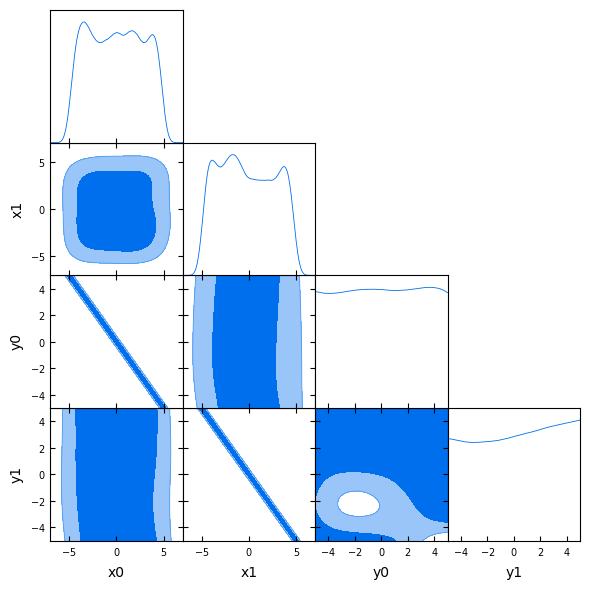

In [9]:
# Show the distribution
mcs = MCSamples(samples=csampler.xsamples, names=csampler.xnames, ranges=csampler.xranges)

g = plots.get_single_plotter(ratio=1)
g.triangle_plot([mcs], filled=True)
plt.show()

In [10]:
# If you want to control `y` to be uniform using the Sobol sequene, we insted do

# xranges = {'x':(-7,7,fresnel.ndim)}
# pranges = {'y':(-5,5,fresnel.ndim)}
# csampler = sampler.ConditionallikelihoodSampler(like, xranges, pranges)
# csampler.sample_xpsamples(50, 50, 10, num_psamples=10, xprogress_bar=True, pprogress_bar=False)

# In this example we smaple num_psamples=10 `y` using Sobol sequence.

## NDE (normalizing flow)

In [11]:
# In the above analysis, we treated x and y as random variables.
# The first half of the `xsamples` in `csmapler` are x samples, and the second half are y samples.
xsamples = csampler.xsamples[:,:fresnel.ndim]
ysamples = csampler.xsamples[:,fresnel.ndim:]
print(xsamples.shape, ysamples.shape)

# Using these samples of (x,y), we train Normalizing Flow
nde = sampler.NDESampler(xsamples, ysamples, normalize=True, decorrelate=False)

(4900, 2) (4900, 2)


In [12]:
# Neural Spline Flow
nde.buildNSF(hidden_dims=[32]*10, n_transforms=8, range_min=-3, range_max=3, n_bins=30)

# Masked Autoregressive Flow (for now this is failing for some reason, need to be investigated)
# nde.buildMAF(hidden_dims=[32]*10, n_transforms=8)

In [13]:
# Train the network
%time nde.train(patience=20, n_steps=1000, min_delta=0.1, batch_size=256)

Training MAF: 100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]

CPU times: user 2min 33s, sys: 10.7 s, total: 2min 43s
Wall time: 1min 18s


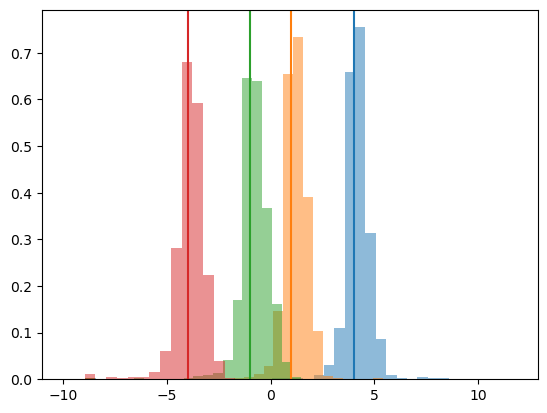

In [14]:
# Now let's see the trained conditional distribution
# In this example we chage the first dimension of y to be -4, -1, 1, 4
# and plot the histgram of the first dimension of x samples

for i, y1 in enumerate([-4.0, -1.0, 1.0, 4.0]):
    y = jnp.array([y1, 0.0])
    xsamples_nde = nde.sample(y, num_samples=2_000)
    plt.hist(xsamples_nde[:,0], bins=40, alpha=0.5, density=True, color='C%d'%i)
    plt.axvline(-y1, color='C%d'%i)
# plt.xlim(-7,7)
plt.show()

## Lets perform the integral using the importance sampling

In [15]:
def perform(y, num_samples=1_000):
    # generate samples and log probability
    x, lnp = nde.sample_and_log_prob(y, num_samples=num_samples, seed=2)
    # perform integral using the samples
    Z, dZ  = fresnel.integrate(x, lnp, t, y=y, error=True)
    return Z, dZ
# vectorize the function
vperform = jax.vmap(perform, in_axes=0, out_axes=0)

In [36]:
# Again, we change the first dimension of y, y=(y1, y2) with y2=0
y1 = jnp.linspace(0.0, 10.0, 200)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2], axis=1)
%time Z, dZ = vperform(y)

CPU times: user 33 ms, sys: 56.1 ms, total: 89.2 ms
Wall time: 20.7 ms


In [37]:
# analytic
%time Za = jnp.pi * jnp.exp(-1j*jnp.pi/2) * jnp.exp(1j*y1**2)

CPU times: user 10.8 s, sys: 1.37 s, total: 12.2 s
Wall time: 2.78 s


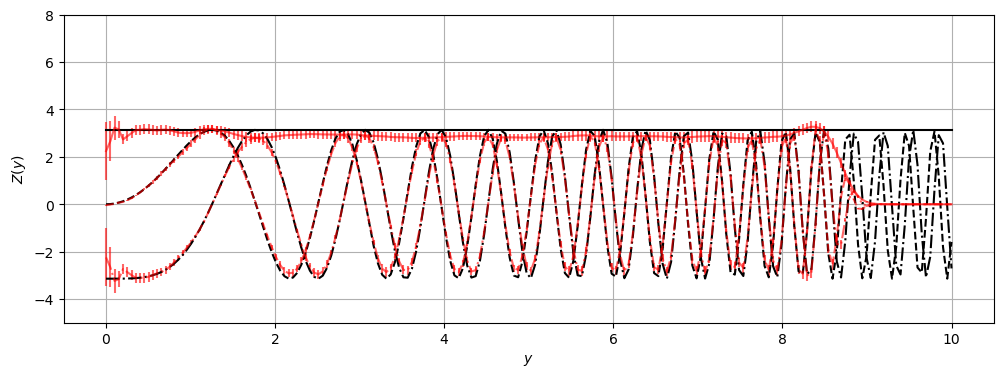

In [39]:
# Plotting
plt.figure(figsize=(12, 4))
# estimate
plt.errorbar(y1, jnp.real(Z), jnp.real(dZ), color='r', ls='--', alpha=0.6)
plt.errorbar(y1, jnp.imag(Z), jnp.imag(dZ), color='r', ls='-.', alpha=0.6)
plt.errorbar(y1, jnp.abs(Z) , jnp.abs(dZ) , color='r', ls='-' , alpha=0.6)
# exact
plt.plot(y1, jnp.real(Za), color='k', ls='--')
plt.plot(y1, jnp.imag(Za), color='k', ls='-.')
plt.plot(y1, jnp.abs(Za) , color='k', ls='-')

plt.ylim(-5,8)
plt.grid()
plt.xlabel(r'$y$')
plt.ylabel(r'$Z(y)$')
plt.show()